### Cryptocurrency Price Prediction Using Deep Learning

1.Getting real-time crptocurrency data.

2.Prepare data for training and testing.

3.Predict the price of crptocurrency using LSTM neural network.

4.Visualize the prediction results.

### Getting real-time crptocurrency data.

In [30]:
import json

import requests

from keras.models import Sequential

from keras.layers import Activation, Dense,Dropout, LSTM

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline

In [8]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'

res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')

hist = pd.DataFrame(json.loads(res.content)['Data'])

hist = hist.set_index('time')

hist.index = pd.to_datetime(hist.index, unit='s')

target_col = 'close'

In [9]:
hist.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-03-04,65570.48,60509.31,64228.63,174.46,10967905.07,61840.50,direct,
2021-03-05,62891.37,59116.18,61840.50,102.15,6215073.91,61979.50,direct,
2021-03-06,62454.99,60340.63,61979.50,42.57,2617685.66,62006.53,direct,
2021-03-07,65221.69,62006.53,62006.53,59.76,3829634.32,64811.33,direct,
2021-03-08,66349.51,63165.39,64811.33,72.80,4707999.02,66349.50,direct,


In [10]:
#  save the hist into csv

hist.to_csv('hist.csv')

In [21]:
# read the downloaded hist

hist = pd.read_csv('hist.csv')

Split the data into two sets — training set and test set with 80% and 20% data respectively. 
The decision made here is just for the purpose of this tutorial. In real projects, you should always split your data into training, validation, testing (like 60%, 20%, 20%).

In [22]:
def train_test_split(df,test_size=0.2):
    split_row = len(df) - int(test_size * len(df)) # the total column of data - the test size of total column length
    train_data = df.iloc[:split_row]
    test_data = df.iloc[:split_row]
    
    return train_data, test_data


In [23]:
train, test = train_test_split(hist,test_size=0.2)

plotting cryptocurrencies prices in canadian dollars as function of time 



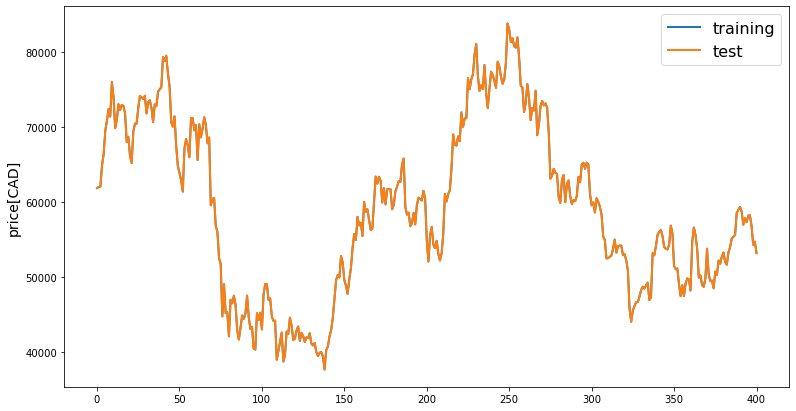

In [27]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1,figsize=(13,7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price[CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best',fontsize=16)

line_plot(train[target_col],test[target_col],'training','test',title='')

In [29]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

extract data of windows which are of size 5

In [31]:
def extract_window_data(df, window_len=5, zero_base=True):

    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
        
    return np.array(window_data)

Make a function to prepare the data in a format to be later fed into the neural network. Use the same concept of splitting the data into two sets — training set and test set with 80% and 20% data respectively.

In [32]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

### LSTM

It works by using special gates to allow each LSTM layer to take information from both previous layers and the current layer. The data goes through multiple gates (like forget gate, input gate, etc.) and various activation functions (like the tanh function, relu function) and is passed through the LSTM cells. The main advantage of this is that it allows each LSTM cell to remember patterns for a certain amount of time. The thing to be noted is that LSTM can remember important information and at the same time forget irrelevant information

In [33]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

Next,  set up some of the parameters to be used later. These parameters are — random number seed, length of the window, test set size, number of neurons in LSTM layer, epochs, batch size, loss, dropouts and optimizer.

In [34]:
np.random.seed(42)

window_len = 5

test_size = 0.2

zero_base = True

lstm_neurons = 100

epochs = 20

batch_size = 32

loss = 'mse'

dropout = 0.2

optimizer = 'adam'

Train models using inputs for x_train and y_train.

In [35]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
    
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

### Mean Absolute Error
It measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between actual and predicted observations where all individual differences have equal weight.

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

### Conclusions
In this article, I demonstrated how to predict cryptocurrency prices in real time using LSTM neural network. I went through a four step process of getting real-time crptocurrency data, preparing data for training and testing, predicting the prices using LSTM neural network and visualizing the prediction results. Feel free to play with the hyper-parameters or try out different neural network architectures for better results.